Description: 3 DoF model from Parafoil control authority for landing on Titan.
Wind is sampled from a Gaussian processed fitted to previous launch day.
Air density model from Autonomous parafoil precision landing using convex real-time
optimized guidance and control.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import scipy as sp

In [109]:
class Parafoil:
    def __init__(self, m, C_L, C_D,S):
        self.m = m
        self.C_L = C_L
        self.C_D = C_D
        self.S = S
    def get_phi(self, t, state, wind):
        """banking angle control"""
        Va, gamma, chi, x, y, z = tuple(state)
        
        dest = np.array([100,250])
        heading = np.array([np.sin(chi), np.cos(chi)])
        target = dest - np.array([x,y])
        target = target/np.linalg.norm(target)
        
        return np.arccos(np.dot(target, heading))#np.pi/64


In [110]:
class Environment:
    def __init__(self, wind_data, g=9.81, c_h = 1.225, c_rho = 2.256e-5, c_e=4.2559):
        kernel = DotProduct() + WhiteKernel()
        self.wind_model = GaussianProcessRegressor(kernel=kernel, n_targets=2)
        self.wind_model = self.wind_model.fit(wind_data[:,0].reshape(-1,1),np.log(wind_data[:,1:]))
        self.g = g
        self.c_h = c_h
        self.c_rho = c_rho
        self.c_e = c_e
    def get_wind(self, height):
        height = -height
        dir, vel = np.exp(self.wind_model.sample_y([[height]], random_state=None)).flatten()
        dir = dir/180 * np.pi
        wind = np.array([vel*np.cos(dir), vel*np.sin(dir),0])
        
        return wind
        #return np.array([0,0,0])
    
    def get_density(self, height):
        height = -height
        return self.c_h * (1 + height * self.c_rho)**self.c_e # + height instead of - because z axis is pointing down

In [111]:
class Dynamics:
    def __init__(self, parafoil, environment):
        self.para = parafoil
        self.env = environment
    def ode(self, time, state):
        Va, gamma, chi, x, y, z = tuple(state)
        
        L = 0.5 * self.env.get_density(z) * Va**2 * self.para.S * self.para.C_L  
        
        D = 0.5 * self.env.get_density(z) * Va**2 * self.para.S * self.para.C_D  
        
        m = self.para.m
        g = self.env.g
      
        wind = self.env.get_wind(z)
        
        phi = self.para.get_phi(time, state, wind)
        
        R_wn = self.wind_to_ground(gamma, chi, phi)
        
        Va_dot = -1/m * (D + m * g * np.sin(gamma))
        
        gamma_dot = 1/(m * Va) * (L * np.cos(phi) - m * g * np.cos(gamma))
        
        chi_dot = (L * np.sin(phi))/(m*Va*np.cos(gamma))
        
        xyz_dot = R_wn.T @ np.array([Va,0,0]) + wind
        
        return np.concatenate([np.array([Va_dot, gamma_dot, chi_dot]), xyz_dot])
        
    def wind_to_ground(self, gamma, chi, phi):
        c_gamma = np.cos(gamma)
        s_gamma = np.sin(gamma)
        c_chi = np.cos(chi)
        s_chi = np.sin(chi)
        c_phi = np.cos(phi)
        s_phi = np.sin(phi)
        return np.array([
            [c_chi * c_gamma , s_chi * c_gamma, -s_gamma],
            [c_chi * s_gamma * s_phi - s_chi * c_phi, s_chi * s_gamma * s_phi + c_chi * c_phi, c_gamma * s_phi],
            [c_chi * s_gamma * c_phi + s_chi * s_phi, s_chi * s_gamma * c_phi - c_chi * s_phi, c_gamma * c_phi]
        ])
    
    
    def simulate(self, t_end, init_Va, init_gamma, init_chi, init_z):
        """
        require stop time, initial_airspeed, initial flight angle, initial heading angle, and initial height to run simulation
        
        Important: In the original paper the z axis of the ground frame point towards planet center! Here we invert it at the end so it's pointing up in the results
        """
        self.init_height = init_z
        trajectory = sp.integrate.solve_ivp(self.ode, [0,t_end], [init_Va, init_gamma, init_chi, 0, 0, -init_z])
        t = trajectory.t
        path = trajectory.y[-3:]
        x = path[0]
        y = path[1]
        z = -path[2]
        return t,x,y,z
        
    def visualize(self, t, x, y, z):
        # 3D plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(211, projection='3d')

        # Plot 3D trajectory
        line = ax.plot(x, y, z, label='Trajectory', linewidth=2)
        line[0].set_color('black')  # Set a color for the line
        
        # Circle on Z=0 plane
        R = self.para.C_L/self.para.C_D * self.init_height  # Set the desired radius
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = R * np.cos(theta)
        circle_y = R * np.sin(theta)
        circle_z = np.zeros_like(theta)
        ax.plot(circle_x, circle_y, circle_z, 'r--', label='Circle on Z=0 plane')
        
        # Label the radius on the graph
        ax.text(0, 0, 0, f"CL/CD*Height = {R}", color='red', fontsize=12, ha='right', va='top')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        ax.set_title('3D Trajectory')

        # Set lower bound for the z-axis to be the Z=0 plane
        ax.set_zlim(bottom=0)

        # 2D plots
        fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

        # Plot t vs x
        axes[0].plot(t, x, label='X')
        axes[0].set_ylabel('X')
        axes[0].set_title('Time vs X')

        # Plot t vs y
        axes[1].plot(t, y, label='Y')
        axes[1].set_ylabel('Y')
        axes[1].set_title('Time vs Y')

        # Plot t vs z
        axes[2].plot(t, z, label='Z')
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Z')
        axes[2].set_title('Time vs Z')

        plt.tight_layout()
        plt.show()
        
        

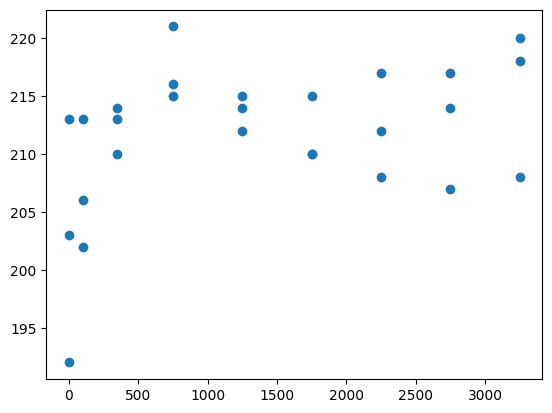

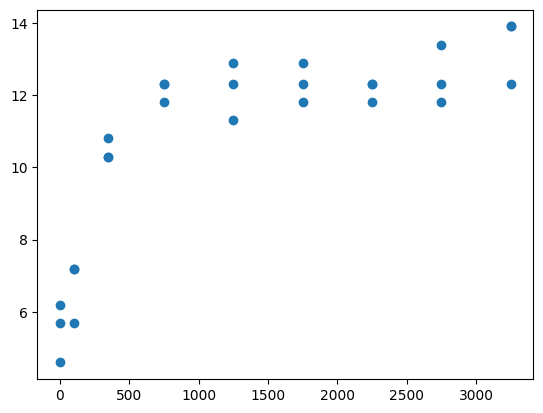

In [112]:

# Specify the file path
file_path = "wind_profile.txt"

# Load the CSV file into a NumPy array, skipping the header
data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
plt.scatter(data[:,0], data[:,1])
plt.show()
plt.scatter(data[:,0], data[:,2])
plt.show()


In [113]:
parafoil = Parafoil(1.9, 0.25,0.15, 1)
environment = Environment(data)
dynamics = Dynamics(parafoil, environment)

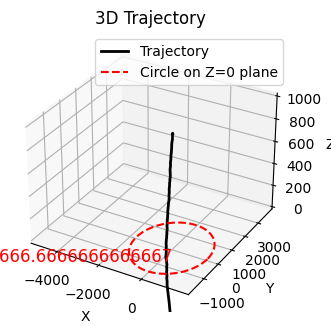

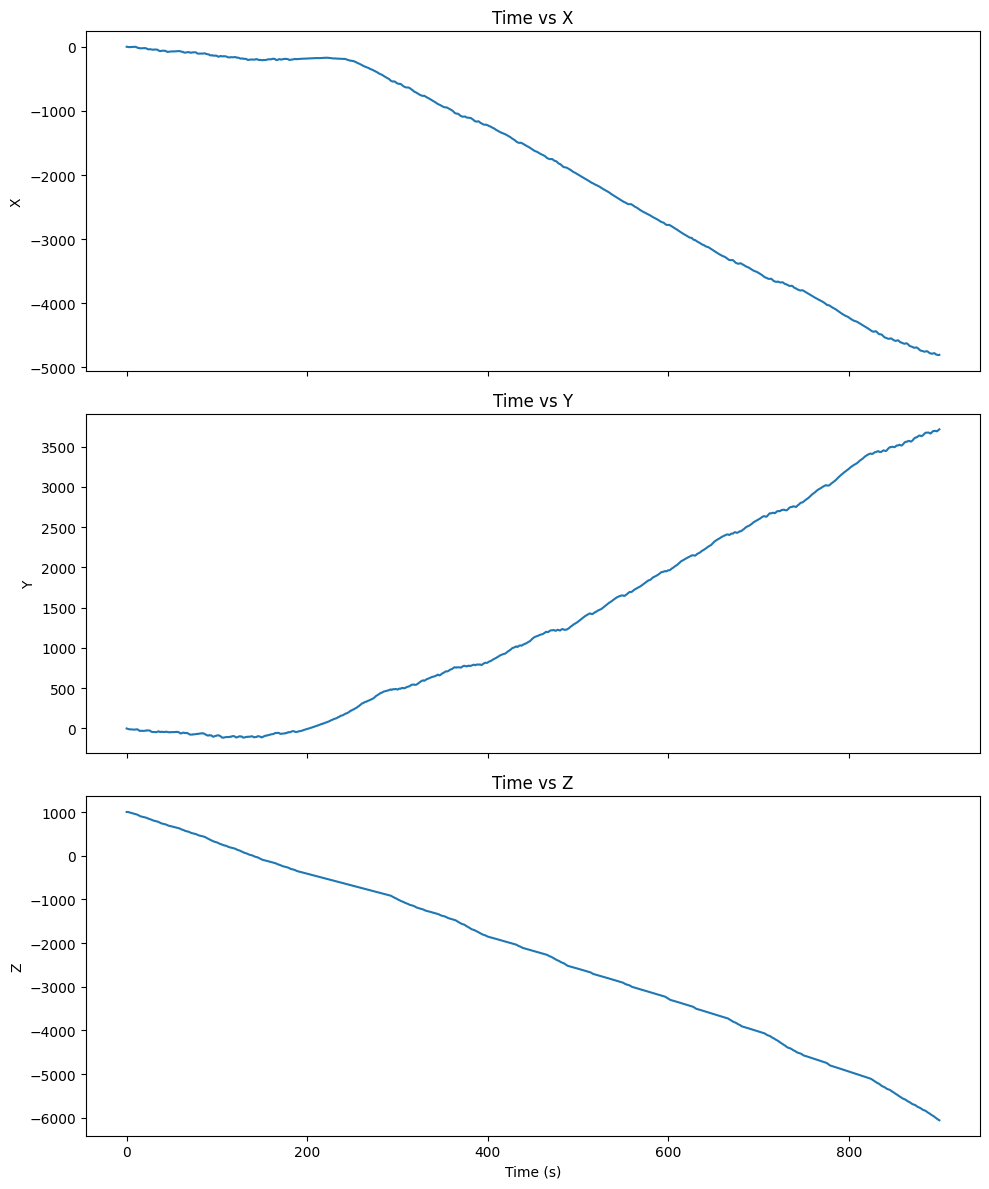

In [115]:
t,x,y,z = dynamics.simulate(900,10,np.pi/4,0,1000)
dynamics.visualize(t,x,y,z)

(1000, 2, 1)


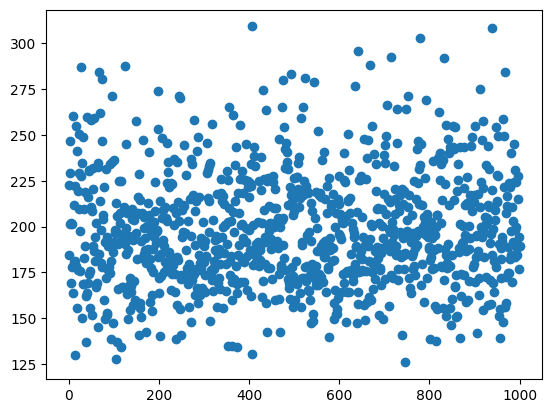

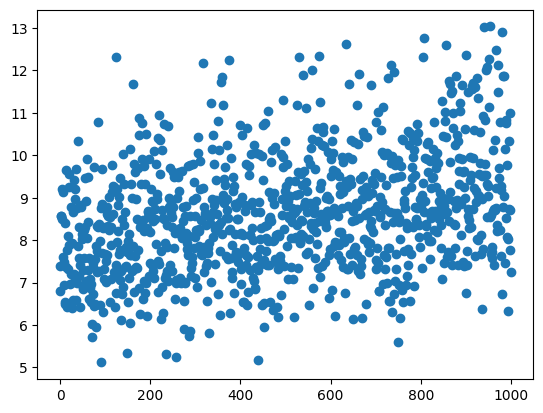